<a href="https://colab.research.google.com/github/Grantar-alt/evol_methods/blob/main/LR4_Variant4_COCOMO_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4  
## Эволюционные алгоритмы оценки стоимости проектов в программной инженерии  
### Вариант 4

**Цель:** разработать эволюционный алгоритм для настройки параметров модели **COCOMO** и выполнить графическое представление результатов.

---

## Постановка задачи

Модель **COCOMO** (в упрощённом виде) оценивает трудоёмкость проекта (в человеко-месяцах) по длине кода $L$ (в килостроках):

$$
Ef = a \cdot L^{b},
$$

где:

- $Ef$ — оценка стоимости (трудоёмкости) проекта, чел.-мес.;  
- $L$ — длина кода, KLOC;  
- $a, b$ — коэффициенты (параметры) модели.

Требуется подобрать $a$ и $b$ по обучающей выборке (данные проектов NASA), минимизируя ошибку, и затем проверить качество на тестовой выборке.

---

## Вариант 4 (по таблице вариантов из методических материалов)

- **Тип алгоритма:** генетический алгоритм (ГА)  
- **Кодирование решения:** вещественный вектор $(a, b)$  
- **Фитнесс-функция:** $ED$  
- **Оператор кроссовера:** арифметический  
- **Оператор мутации:** арифметический (вещественная мутация)  
- **Оператор репродукции:** рулетка (roulette wheel selection)

---

## Используемые данные

Используем сокращённую таблицу экспериментальных данных NASA (18 проектов): для каждого проекта заданы $L$ и реальная трудоёмкость $Ef$.
Из 18 проектов случайно выбираем 13 для обучения и 5 для тестирования (с фиксированным seed для воспроизводимости).


In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Чтобы графики выглядели одинаково в Colab/Notebook
plt.rcParams['figure.dpi'] = 120


## Теоретические сведения

### Ошибка $ED$ (в методических материалах)

В данной работе в качестве фитнес-функции используется метрика $ED$ (как она задана в пособии):

$$
ED = \frac{1}{n} \sum_{i=1}^{n} \left|Ef_i - Efm_i\right|,
$$

где $Ef_i$ — реальная трудоёмкость $i$-го проекта, а $Efm_i$ — модельная оценка по формуле $Ef=aL^b$.

По смыслу это **средняя абсолютная ошибка** (MAE), но в методических материалах она обозначена как $ED$.

---

### Генетический алгоритм (кратко)

1. Сформировать начальную популяцию кандидатов $x=(a,b)$ в допустимых диапазонах.  
2. Для каждой особи вычислить фитнесс (ошибку $ED$ на обучающем множестве).  
3. Повторять по поколениям:
   - выбрать родителей (рулетка);
   - выполнить кроссовер (арифметический);
   - выполнить мутацию (вещественная/арифметическая);
   - сформировать новое поколение (с элитизмом);
   - сохранять лучшую особь и значение ошибки.
4. Вернуть найденные $a$ и $b$ и оценить качество на тестовом множестве.


In [2]:
# Данные NASA (18 проектов): L (KLOC) и реальная трудоёмкость Ef (чел.-мес.)
L = np.array([90.2, 46.2, 46.5, 54.5, 31.1, 67.5, 12.8, 10.5, 21.5,
              3.1, 4.2, 7.8, 2.1, 5.0, 78.6, 9.7, 12.5, 100.8], dtype=float)

Ef = np.array([115.8, 96.0, 79.0, 90.8, 39.6, 98.4, 18.9, 10.3, 28.5,
               7.0, 9.0, 7.3, 5.0, 8.4, 98.7, 15.6, 23.9, 138.3], dtype=float)

df = pd.DataFrame({
    "project": np.arange(1, len(L) + 1),
    "L_KLOC": L,
    "Ef_real": Ef
})
df


,project,L_KLOC,Ef_real
0,1,90.2,115.8
1,2,46.2,96.0
2,3,46.5,79.0
3,4,54.5,90.8
4,5,31.1,39.6
5,6,67.5,98.4
6,7,12.8,18.9
7,8,10.5,10.3
8,9,21.5,28.5
9,10,3.1,7.0


In [3]:
# Разбиение на обучающее (13) и тестовое (5) множества
def train_test_split_indices(n: int, train_size: int, seed: int = 123):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    train_idx = np.sort(idx[:train_size])
    test_idx = np.sort(idx[train_size:])
    return train_idx, test_idx

SEED_SPLIT = 123
train_idx, test_idx = train_test_split_indices(len(L), train_size=13, seed=SEED_SPLIT)

print("Train idx:", train_idx, "=> projects", (train_idx + 1))
print("Test idx :", test_idx,  "=> projects", (test_idx + 1))
print("Train size:", len(train_idx), "| Test size:", len(test_idx))


Train idx: [ 0  1  2  4  7  8  9 10 12 14 15 16 17] => projects [ 1  2  3  5  8  9 10 11 13 15 16 17 18]
Test idx : [ 3  5  6 11 13] => projects [ 4  6  7 12 14]
Train size: 13 | Test size: 5


### Диапазоны коэффициентов

В расчётах используем ограничения (как в примерах пособия):

- $$a \in [0; 10]$$
- $$b \in [0.3; 2]$$


In [4]:
# Модель COCOMO (упрощённая) и метрики ошибок
def cocomo_predict(L: np.ndarray, a: float, b: float) -> np.ndarray:
    return a * (L ** b)

def ed_metric(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # ED = 1/n * sum |Ef - Efm|
    return float(np.mean(np.abs(y_true - y_pred)))

# Дополнительно (необязательно, но полезно для отчётности/сравнения)
def md_metric(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # MD = sum |Ef - Efm|
    return float(np.sum(np.abs(y_true - y_pred)))

def mmre_metric(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # MMRE = (1/n) * sum (|Ef - Efm| / Ef)
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred) / y_true))

def rms_metric(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # RMS = sqrt( (1/n) * sum (Ef - Efm)^2 )
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


In [5]:
# Генетический алгоритм (вещественный вектор (a,b), ED, рулетка, арифметические операторы)

@dataclass
class GAConfig:
    pop_size: int = 80
    generations: int = 250
    pc: float = 0.90          # вероятность кроссовера
    pm: float = 0.25          # вероятность мутации (на уровне особи)
    a_bounds: tuple = (0.0, 10.0)
    b_bounds: tuple = (0.3, 2.0)
    mutation_sigma_frac: float = 0.08  # доля диапазона (sigma = frac * (ub-lb))
    elitism: int = 2          # сколько лучших переносим без изменений
    seed: int = 7

def ga_optimize_ab(L_train: np.ndarray, y_train: np.ndarray, cfg: GAConfig):
    rng = np.random.default_rng(cfg.seed)
    a_lo, a_hi = cfg.a_bounds
    b_lo, b_hi = cfg.b_bounds

    # 1) Инициализация популяции
    pop = np.empty((cfg.pop_size, 2), dtype=float)
    pop[:, 0] = rng.uniform(a_lo, a_hi, size=cfg.pop_size)  # a
    pop[:, 1] = rng.uniform(b_lo, b_hi, size=cfg.pop_size)  # b

    def fitness(ind: np.ndarray) -> float:
        a, b = float(ind[0]), float(ind[1])
        pred = cocomo_predict(L_train, a, b)
        return ed_metric(y_train, pred)

    fit = np.array([fitness(ind) for ind in pop], dtype=float)

    history = {
        "best_fit": [],
        "mean_fit": [],
        "best_a": [],
        "best_b": []
    }

    sigma_a = cfg.mutation_sigma_frac * (a_hi - a_lo)
    sigma_b = cfg.mutation_sigma_frac * (b_hi - b_lo)
    eps = 1e-12

    # 2) Основной цикл поколений
    for g in range(cfg.generations):
        # сортировка по качеству (min)
        order = np.argsort(fit)
        pop = pop[order]
        fit = fit[order]

        history["best_fit"].append(float(fit[0]))
        history["mean_fit"].append(float(fit.mean()))
        history["best_a"].append(float(pop[0, 0]))
        history["best_b"].append(float(pop[0, 1]))

        # 2.1) Рулетка (для минимизации: преобразуем в максимизацию через 1/(err+eps))
        inv = 1.0 / (fit + eps)
        probs = inv / inv.sum()

        new_pop = []

        # 2.2) Элитизм
        for i in range(cfg.elitism):
            new_pop.append(pop[i].copy())

        # 2.3) Генерация потомков
        while len(new_pop) < cfg.pop_size:
            p1 = pop[rng.choice(cfg.pop_size, p=probs)]
            p2 = pop[rng.choice(cfg.pop_size, p=probs)]

            c1, c2 = p1.copy(), p2.copy()

            # арифметический кроссовер
            if rng.random() < cfg.pc:
                alpha = rng.random()
                c1 = alpha * p1 + (1.0 - alpha) * p2
                c2 = alpha * p2 + (1.0 - alpha) * p1

            # арифметическая (вещественная) мутация: гауссовское возмущение
            for c in (c1, c2):
                if rng.random() < cfg.pm:
                    # мутация генов независимо
                    if rng.random() < 0.5:
                        c[0] += rng.normal(0.0, sigma_a)
                    if rng.random() < 0.5:
                        c[1] += rng.normal(0.0, sigma_b)

                # ограничение диапазона
                c[0] = float(np.clip(c[0], a_lo, a_hi))
                c[1] = float(np.clip(c[1], b_lo, b_hi))

            new_pop.append(c1)
            if len(new_pop) < cfg.pop_size:
                new_pop.append(c2)

        pop = np.array(new_pop[:cfg.pop_size], dtype=float)
        fit = np.array([fitness(ind) for ind in pop], dtype=float)

    # вернуть лучший результат последнего поколения
    order = np.argsort(fit)
    pop = pop[order]
    fit = fit[order]
    best = pop[0]
    best_fit = float(fit[0])
    return best, best_fit, history


In [6]:
# Запуск ГА (обучение на 13 проектах)
cfg = GAConfig()
best, best_fit, hist = ga_optimize_ab(L[train_idx], Ef[train_idx], cfg)

a_best, b_best = float(best[0]), float(best[1])

print("Лучшие коэффициенты (a, b):", (a_best, b_best))
print("ED на обучающем множестве:", best_fit)


Лучшие коэффициенты (a, b): (2.0211414786092403, 0.8994011655000507)
ED на обучающем множестве: 6.525571587094178


In [7]:
# Базовая (стандартная) COCOMO-оценка для сравнения
# Для "простых" проектов часто используют a=2.4, b=1.05 (упрощённый базовый уровень).
a0, b0 = 2.4, 1.05

pred_cocomo = cocomo_predict(L, a0, b0)
pred_ga = cocomo_predict(L, a_best, b_best)

ed_train_cocomo = ed_metric(Ef[train_idx], pred_cocomo[train_idx])
ed_test_cocomo  = ed_metric(Ef[test_idx],  pred_cocomo[test_idx])

ed_train_ga = ed_metric(Ef[train_idx], pred_ga[train_idx])
ed_test_ga  = ed_metric(Ef[test_idx],  pred_ga[test_idx])

print("ED (train) COCOMO:", ed_train_cocomo)
print("ED (test)  COCOMO:", ed_test_cocomo)
print("ED (train) GA    :", ed_train_ga)
print("ED (test)  GA    :", ed_test_ga)


ED (train) COCOMO: 51.88163861098102
ED (test)  COCOMO: 40.91382211229022
ED (train) GA    : 6.525571587094178
ED (test)  GA    : 6.611253674525974


In [8]:
# Итоговая таблица (реальные значения, прогнозы и ошибки)
subset = np.array(["train"] * len(L), dtype=object)
subset[test_idx] = "test"

res = pd.DataFrame({
    "project": np.arange(1, len(L) + 1),
    "subset": subset,
    "L_KLOC": L,
    "Ef_real": Ef,
    "Ef_COCOMO": pred_cocomo,
    "Ef_GA": pred_ga,
    "abs_err_COCOMO": np.abs(Ef - pred_cocomo),
    "abs_err_GA": np.abs(Ef - pred_ga)
})

res


,project,subset,L_KLOC,Ef_real,Ef_COCOMO,Ef_GA,abs_err_COCOMO,abs_err_GA
0,1,train,90.2,115.8,271.130332,115.907557,155.330332,0.107557
1,2,train,46.2,96.0,134.302877,63.500574,38.302877,32.499426
2,3,train,46.5,79.0,135.218727,63.871313,56.218727,15.128687
3,4,test,54.5,90.8,159.745109,73.673916,68.945109,17.126084
4,5,train,31.1,39.6,88.635898,44.482291,49.035898,4.882291
5,6,test,67.5,98.4,199.977071,89.304771,101.577071,9.095229
6,7,test,12.8,18.9,34.896487,20.018091,15.996487,1.118091
7,8,train,10.5,10.3,28.343926,16.751572,18.043926,6.451572
8,9,train,21.5,28.5,60.154985,31.914895,31.654985,3.414895
9,10,train,3.1,7.0,7.873014,5.591496,0.873014,1.408504


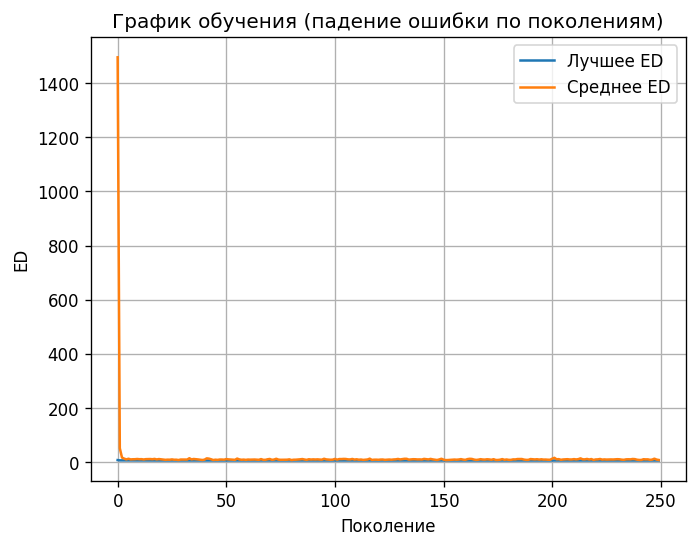

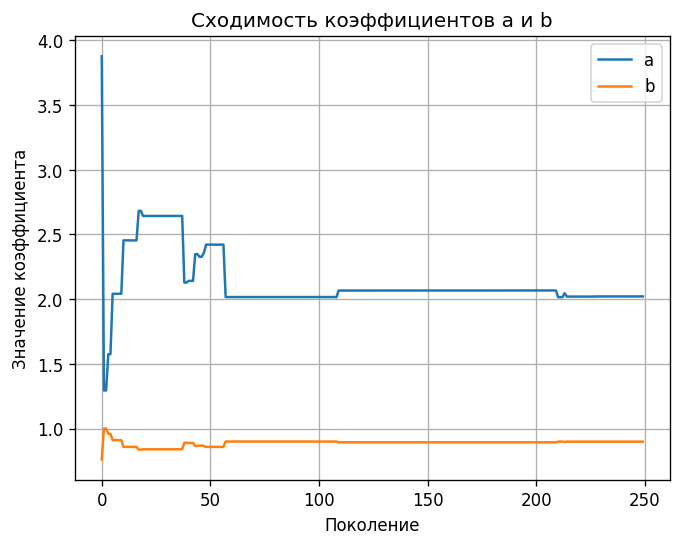

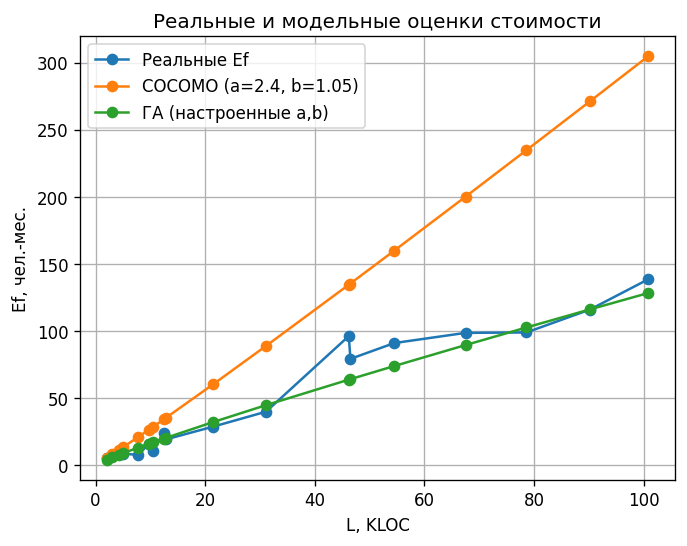

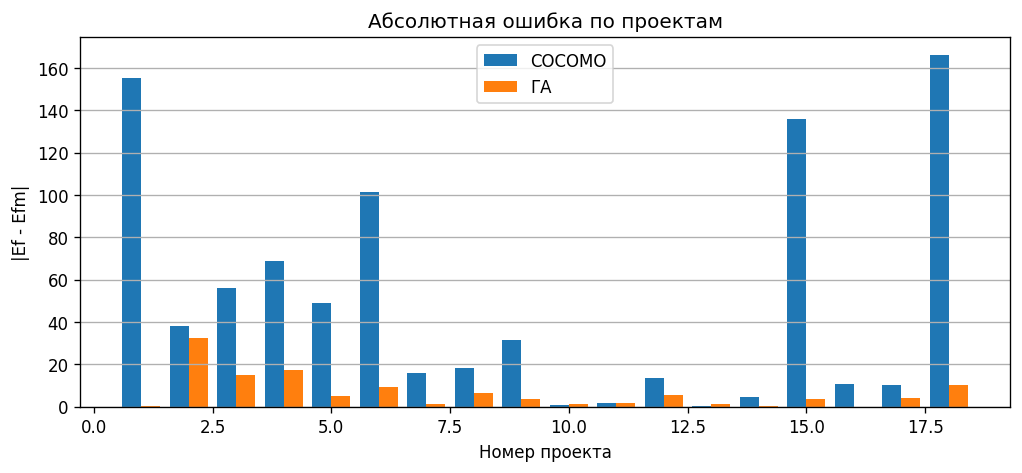

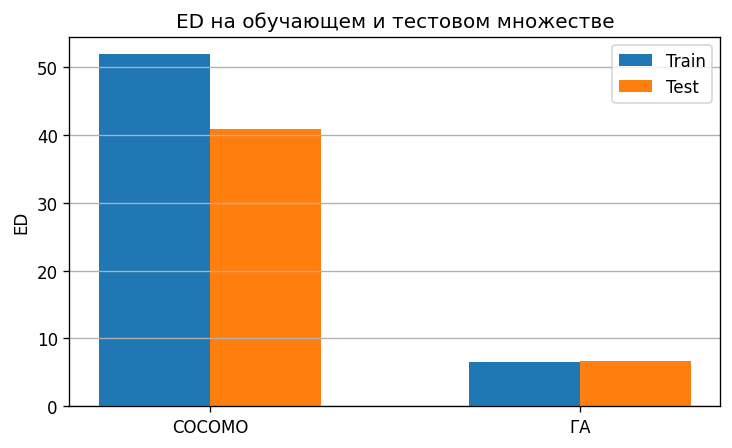

In [9]:
# Визуализация результатов

# 1) График обучения (сходимость)
plt.figure()
plt.plot(hist["best_fit"], label="Лучшее ED")
plt.plot(hist["mean_fit"], label="Среднее ED")
plt.xlabel("Поколение")
plt.ylabel("ED")
plt.title("График обучения (падение ошибки по поколениям)")
plt.grid(True)
plt.legend()
plt.show()

# 2) Сходимость коэффициентов a и b
plt.figure()
plt.plot(hist["best_a"], label="a")
plt.plot(hist["best_b"], label="b")
plt.xlabel("Поколение")
plt.ylabel("Значение коэффициента")
plt.title("Сходимость коэффициентов a и b")
plt.grid(True)
plt.legend()
plt.show()

# 3) Реальная и модельная стоимость (сортировка по L)
order = np.argsort(L)

plt.figure()
plt.plot(L[order], Ef[order], marker='o', label="Реальные Ef")
plt.plot(L[order], pred_cocomo[order], marker='o', label="COCOMO (a=2.4, b=1.05)")
plt.plot(L[order], pred_ga[order], marker='o', label="ГА (настроенные a,b)")
plt.xlabel("L, KLOC")
plt.ylabel("Ef, чел.-мес.")
plt.title("Реальные и модельные оценки стоимости")
plt.grid(True)
plt.legend()
plt.show()

# 4) Абсолютная ошибка по проектам
err_c = np.abs(Ef - pred_cocomo)
err_g = np.abs(Ef - pred_ga)
x = np.arange(1, len(L) + 1)

plt.figure(figsize=(10, 4))
plt.bar(x - 0.2, err_c, width=0.4, label="COCOMO")
plt.bar(x + 0.2, err_g, width=0.4, label="ГА")
plt.xlabel("Номер проекта")
plt.ylabel("|Ef - Efm|")
plt.title("Абсолютная ошибка по проектам")
plt.grid(True, axis='y')
plt.legend()
plt.show()

# 5) Диаграмма ошибок на обучающем и тестовом множестве
labels = ["COCOMO", "ГА"]
train_vals = [ed_train_cocomo, ed_train_ga]
test_vals  = [ed_test_cocomo,  ed_test_ga]

plt.figure(figsize=(7, 4))
plt.bar(np.arange(len(labels)) - 0.15, train_vals, width=0.3, label="Train")
plt.bar(np.arange(len(labels)) + 0.15, test_vals,  width=0.3, label="Test")
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel("ED")
plt.title("ED на обучающем и тестовом множестве")
plt.grid(True, axis='y')
plt.legend()
plt.show()


## Найденная модель

По результатам работы генетического алгоритма получены коэффициенты:

$$
a = \text{(см. вывод в ячейке выше)}, \quad b = \text{(см. вывод в ячейке выше)}.
$$

Итоговая формула модели:

$$
Ef = a \cdot L^{b}.
$$

Для удобства ниже добавлена ячейка, которая печатает формулу уже с численными значениями.


In [10]:
# Печать итоговой формулы с найденными коэффициентами
print(f"Ef = {a_best:.6f} * L^{b_best:.6f}")


Ef = 2.021141 * L^0.899401


## Контрольные вопросы (краткие ответы)

1. **Основная формула COCOMO (упрощённая):**  
   $$Ef = a\cdot L^{b}.$$

2. **Какие данные нужны для использования COCOMO?**  
   Минимально — $L$ (размер ПО в KLOC). В расширенных вариантах — набор множителей/факторов проекта ($E_m$) и параметры, описывающие команду, среду, надёжность и т. п.

3. **Что позволяет оценивать COCOMO?**  
   Трудоёмкость/стоимость разработки (часто в чел.-мес.), далее косвенно сроки и бюджет.

4. **Какие данные можно использовать при обучении коэффициентов $a,b$?**  
   Исторические проекты с известными $L$ и фактическим $Ef$ (как в таблице NASA).

5. **Как разбить данные на обучающее и тестовое множество?**  
   Например, случайно (с фиксированным seed) выбрать 13 проектов для обучения и 5 для теста, либо использовать фиксированное разбиение.

6. **Какое кодирование решений возможно?**  
   Двоичное (битовая строка) или вещественное (непосредственно значения $a,b$).

7. **Какие типы генетических операторов можно использовать?**  
   Для вещественного кодирования — арифметический/BLX-$\alpha$/SBX кроссовер, гауссовская/неоднородная мутация, различные схемы селекции (рулетка, турнир, ранговая).

8. **Какую фитнесс-функцию можно использовать?**  
   Любую меру ошибки между реальными $Ef$ и модельными $Efm$: $MD$, $MMRE$, $RMS$, $ED$ и др.

9. **Какие виды ошибок можно использовать?**  
   Абсолютная, относительная, среднеквадратичная, вариабельность и др.

10. **Основная формула метрики абсолютных значений (MD):**  
$$MD=\sum_{i=1}^{n}|Ef_i-Efm_i|.$$

11. **Основная формула MMRE:**  
$$MMRE=\frac{1}{n}\sum_{i=1}^{n}\frac{|Ef_i-Efm_i|}{Ef_i}.$$

12. **Основная формула ED (как в методике):**  
$$ED=\frac{1}{n}\sum_{i=1}^{n}|Ef_i-Efm_i|.$$

13. **Как улучшить методику COCOMO?**  
   Учитывать дополнительные факторы проекта ($E_m$), применять более богатые модели (COCOMO II), а также настраивать параметры на данных организации с помощью ИИ/метаэвристик.

14. **Как применить роевой алгоритм для поиска $a,b$?**  
   Рассматривать частицу как вектор $(a,b)$ и минимизировать выбранную ошибку, обновляя скорости/позиции по правилам PSO.

15. **Как применить эволюционную стратегию для поиска $a,b$?**  
   Рассматривать $(a,b)$ как вектор параметров и использовать $(\mu,\lambda)$ или $(\mu+\lambda)$-ЭС с гауссовской мутацией и отбором по ошибке.
